### Problem Description
We want to create a quantum walk operator for a line of 16 nodes, as shown below.

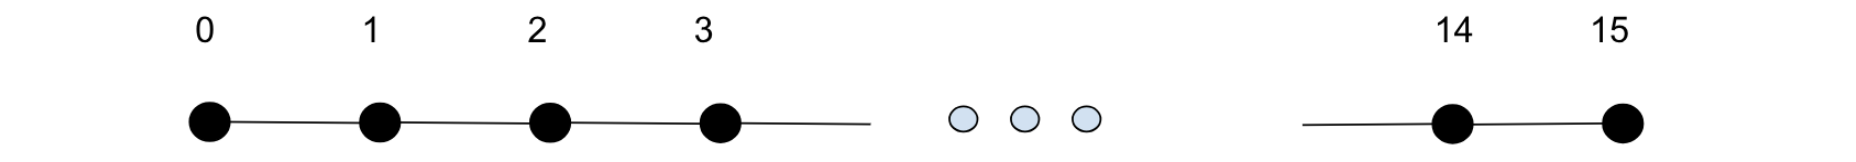


In Bootcamp 4 presentation we have seen an example of a 4 node system where the nodes/vertices are connected as below, as in a circle. Shown below, ech node has two edges with the direct neighbors on either side.

```
  |----(0)-----(1)-----(2)-----(3)-----|
  |                                    |
  |------------------------------------|
```

### About Quantum Walk

In a discrete-time random walk on a graph, at each time step we move from any given vertex to each of its neighbors with equal probability. In Quantum Walk, the quantum analog of this classical random walk, an input state $|j\rangle$ corresponding to the vertex $j ∈ V$ evolves to a superposition of the neighbors of $j$, where $V$ is the set of vertices in the graph. After a new vertices is reached, a swap operation is performed to continue the walk.

[1] - [Lecture Notes on
Quantum Algorithms by Andrew Childs](https://www.cs.umd.edu/~amchilds/qa/qa.pdf)

### Overview of our solution

* We take the base code from Classiq example provided at [quantum_walk_circle_example.py](https://github.com/Classiq/classiq-library/blob/main/community/womanium/assignments/quantum_walk_circle_example.py) (as suggested in the task 6.12 description).
* We identify the code components that will need adjustment for circle vs line etc. 
* Following is a list of differences
  * The graph connectivity map: In case of line, $ Node_0 $ (the first node) and $ Node_{15} $ (the last node) are slightly different, they have only 1 edge each.
    * As a result of the above the probabilities will need to be adjusted accordingly
  * Number of qubits to represent 16 nodes: 4 qubits
* List of functions that are modified to adopt the new line graph
  * `W_iteration()`
  * `edge_oracle()`

We observe that depending on our formulation of the edge oracle function, the synthesized circuit can use more or less number of auxiliary qubits. This is not surprising given that the compute inside this function changes. Ideally we would like an `abs` function there.

Related note - based on a [slack conversation with Tomer Goldfriend](https://classiq-community.slack.com/archives/C04L4RC85U4/p1721229596828479) at Classiq, there is an `classiq.qmod.symbolic.abs` but it is broken for the current latest version of the SDK. An optimal implementation of `abs` may use fewer aux bits.

We will explore the possibility of finding an optimal solution to use minimal number of qubits for our circuit.

### Implementation
The superposition based walk, also referred as coin/walk operator defines the probabilities of the walker moving from one node to another. In our 16 node line grapgh, except the two end vertices (0 and 15), all the nodes are connected to two vertices. The node 0 is connected to only 1 and node 15 is connected to node 14.

A shift operator is applied after determining the movement probabilities.

We keep the graph connectivity map / structure in mind for the combined operations.

In [62]:
from classiq import *
from classiq.qmod.symbolic import abs as classiq_abs
import math

def custom_model(num_qubits, e_oracle_selector=0, quiet=False):
    """
    We create a few (minor) variants for the edge-oracle.
    
    * line graph
    * 0--1--2--...--14--15
    * we have a connected edge, if and only if they are direct neighbors

    For the edge oracle we check if the two nodes are next to each other.
    Which means either +1 or -1 apart. We cannot use (1 or -1) since 
    they get combined into a single value.
    e.g. (1 or -1) = 1
         (1 | -1) = -1
    """
    @qfunc
    def edge_oracle0(res:Output[QBit], v1: QNum, v2: QNum):
        res |= ((v1 - v2) == 1) | ((v1 - v2) == -1)

    @qfunc
    def edge_oracle1(res:Output[QBit], v1: QNum, v2: QNum):
        res |= ((v1 + 1) == v2) | ((v2 + 1) == v1)

    @qfunc
    def edge_oracle2(res:Output[QBit], v1: QNum, v2: QNum):
        res |= ((v1 - v2) == 1) | ((v2 - v1) == 1)

    @qfunc
    def edge_oracle3(res:Output[QBit], v1: QNum, v2: QNum):
        res |= classiq_abs(v1 - v2) == 1

    if e_oracle_selector == 1:
        edge_oracle = edge_oracle1
    elif e_oracle_selector == 2:
        edge_oracle = edge_oracle2
    elif e_oracle_selector == 3:
        edge_oracle = edge_oracle3
    else:
        edge_oracle = edge_oracle0

    @qfunc
    def prepare_minus(x: QBit):
      X(x)
      H(x)
    
    @qfunc
    def diffuzer_oracle(aux: Output[QNum],x:QNum):
      aux^=(x!=0)
    
    @qfunc
    def zero_diffuzer(x: QNum):
      aux = QNum('aux')
      allocate(1,aux)
      within_apply(compute=lambda: prepare_minus(aux),
                  action=lambda: diffuzer_oracle)
    
    def W_iteration(i:int,vertices: QNum, adjacent_vertices:QNum):
        prob = [0] * 2**num_qubits
        # line graph
        # 0--1--2--...--14--15
        if i == 0:
            prob[1] = 1.0
        elif i == (2**num_qubits - 1):
            prob[-2] = 1.0
        else:
            prob[i - 1] = prob[i + 1] = 0.5
        if not quiet:
            print(f'State={i:2d}, prob vec ={prob}')
        
        control(ctrl=vertices==i,
                operand=lambda: within_apply(
                  compute= lambda: inplace_prepare_state(probabilities=prob, bound=0.01, target=adjacent_vertices),
                  action= lambda: zero_diffuzer(adjacent_vertices)))
    
    @qfunc 
    def W_operator(vertices:QNum, adjacent_vertices: QNum):
        for i in range(2**num_qubits):
          W_iteration(i,vertices,adjacent_vertices)
        
    @qfunc 
    def bitwise_swap(x: QArray[QBit], y:QArray[QBit]):
      repeat(count= x.len,
        iteration= lambda i: SWAP(x[i],y[i]))
    
    @qfunc 
    def S_operator(vertices:QNum, adjacent_vertices: QNum):
        res = QNum('res')
        edge_oracle(res,vertices,adjacent_vertices)
        control(ctrl= res==1,
            operand= lambda: bitwise_swap(vertices,adjacent_vertices))
    
    @qfunc 
    def main(vertices:Output[QNum], adjacent_vertices:Output[QNum]):
    
      allocate(num_qubits,vertices)
      hadamard_transform(vertices)
      allocate(num_qubits,adjacent_vertices)
    
      W_operator(vertices,adjacent_vertices)
      S_operator(vertices,adjacent_vertices)
    
    return create_model(main)

### Synthesize a circuit

In [63]:
NUMBER_OF_NODES = 16
num_qubits = math.ceil(math.log(NUMBER_OF_NODES,2))

print(f"INFO:: We are using {num_qubits} qubits for vertices/nodes")

qmod = custom_model(num_qubits=num_qubits)
qprog = synthesize(qmod)
show(qprog)

INFO:: We are using 4 qubits for vertices/nodes
State= 0, prob vec =[0, 1.0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
State= 1, prob vec =[0.5, 0, 0.5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
State= 2, prob vec =[0, 0.5, 0, 0.5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
State= 3, prob vec =[0, 0, 0.5, 0, 0.5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
State= 4, prob vec =[0, 0, 0, 0.5, 0, 0.5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
State= 5, prob vec =[0, 0, 0, 0, 0.5, 0, 0.5, 0, 0, 0, 0, 0, 0, 0, 0, 0]
State= 6, prob vec =[0, 0, 0, 0, 0, 0.5, 0, 0.5, 0, 0, 0, 0, 0, 0, 0, 0]
State= 7, prob vec =[0, 0, 0, 0, 0, 0, 0.5, 0, 0.5, 0, 0, 0, 0, 0, 0, 0]
State= 8, prob vec =[0, 0, 0, 0, 0, 0, 0, 0.5, 0, 0.5, 0, 0, 0, 0, 0, 0]
State= 9, prob vec =[0, 0, 0, 0, 0, 0, 0, 0, 0.5, 0, 0.5, 0, 0, 0, 0, 0]
State=10, prob vec =[0, 0, 0, 0, 0, 0, 0, 0, 0, 0.5, 0, 0.5, 0, 0, 0, 0]
State=11, prob vec =[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.5, 0, 0.5, 0, 0, 0]
State=12, prob vec =[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.5, 0, 0.5, 0, 0]
State

### Sample program / circuit

Following diagram shows the internal building blocks of our quantum walk circuit. As expected with hadamard application we start in an equal superposition state and apply walk/coin operator and swap / shift operator in sequence.

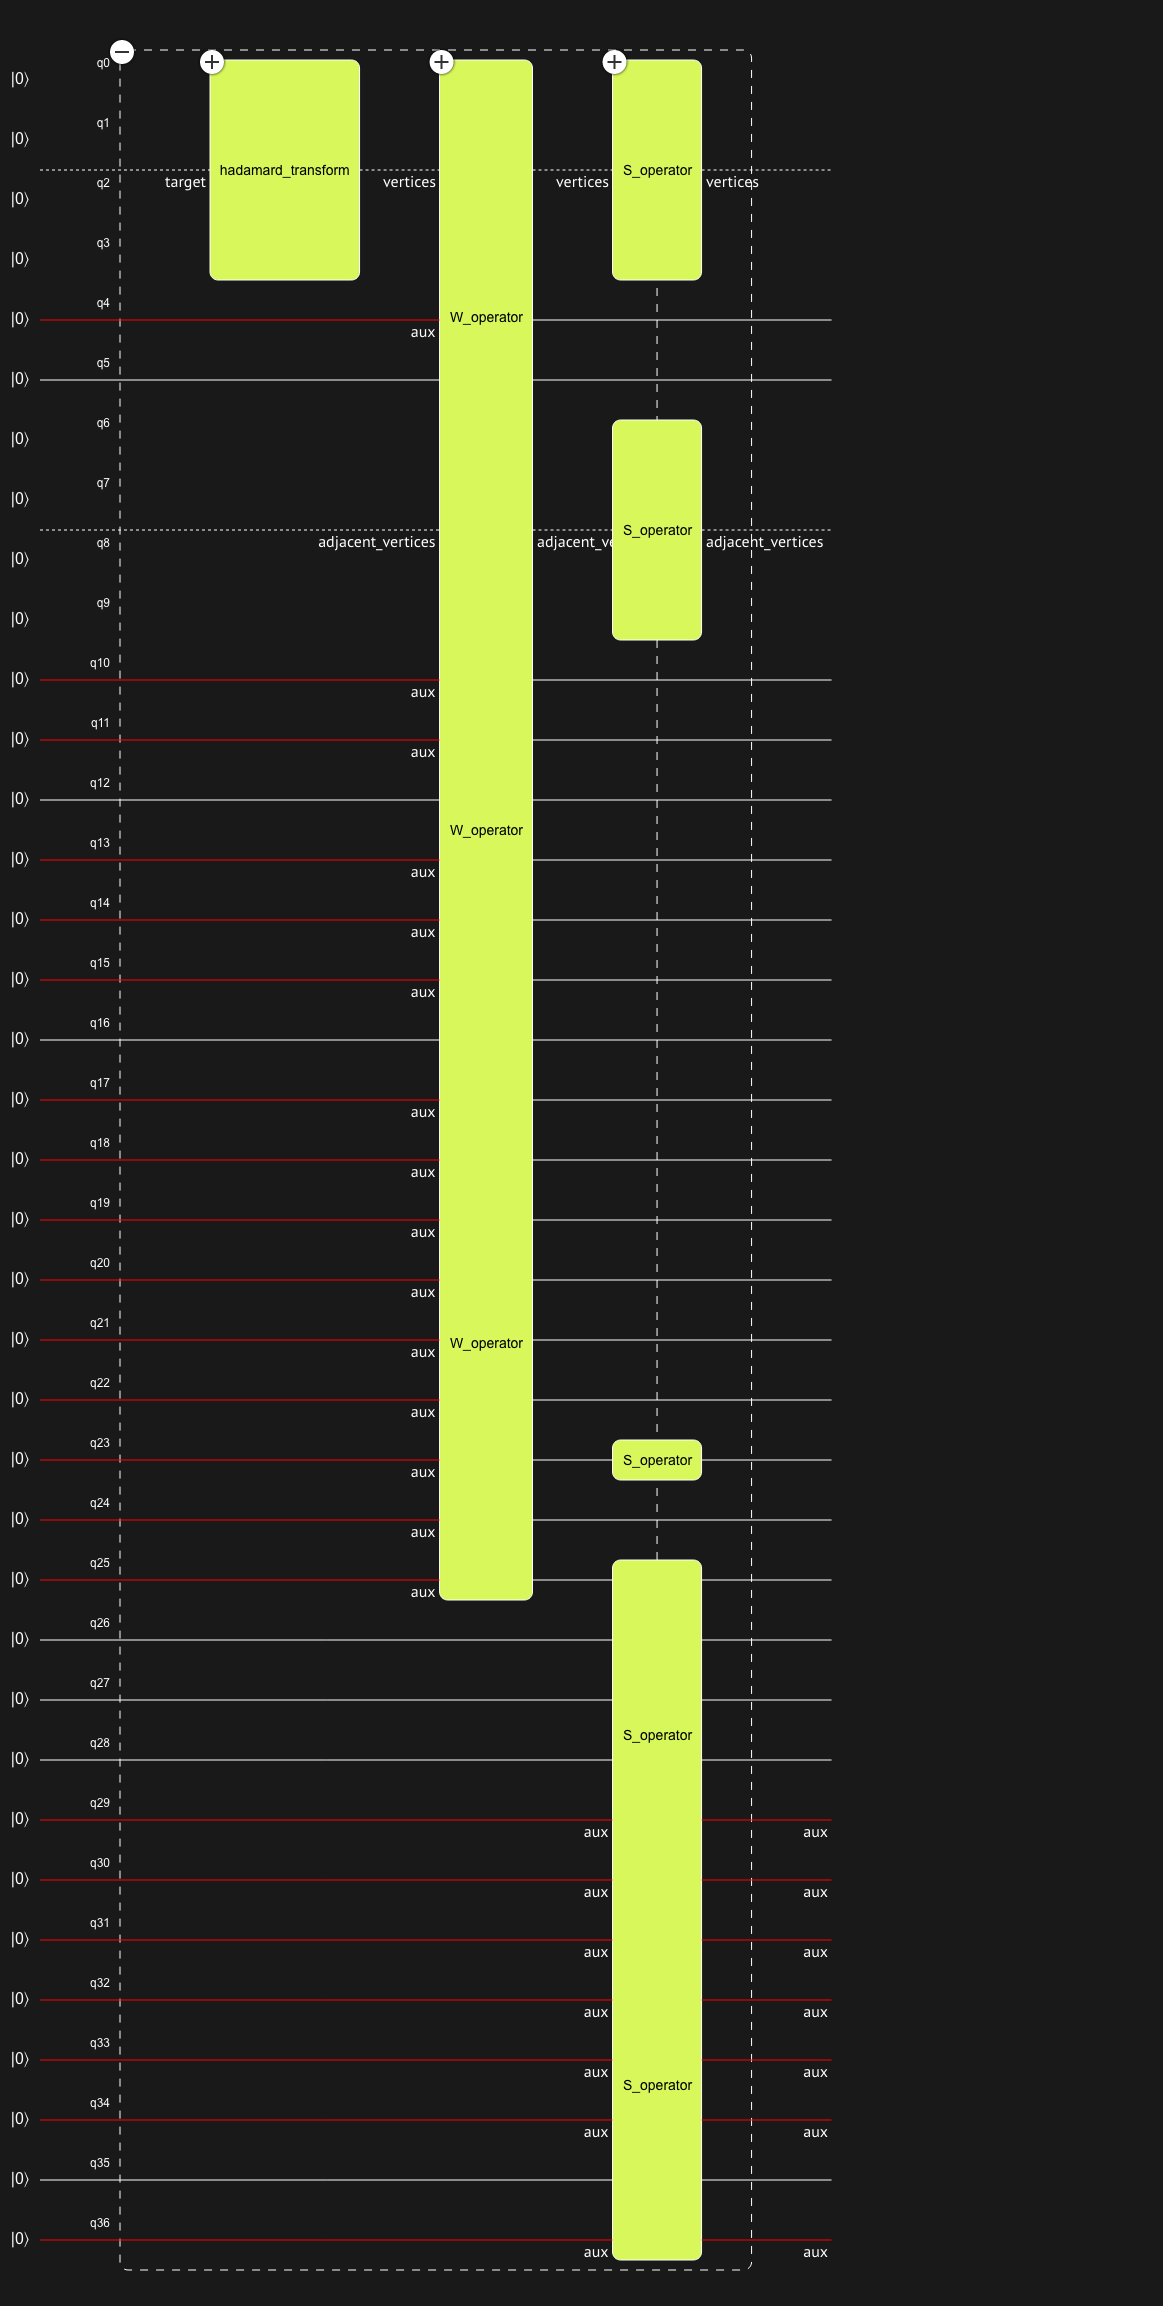

#### Inside the W Operator

The expanded circuit is too wide to see, we crop a small part to see the components as we have programatically defined above.

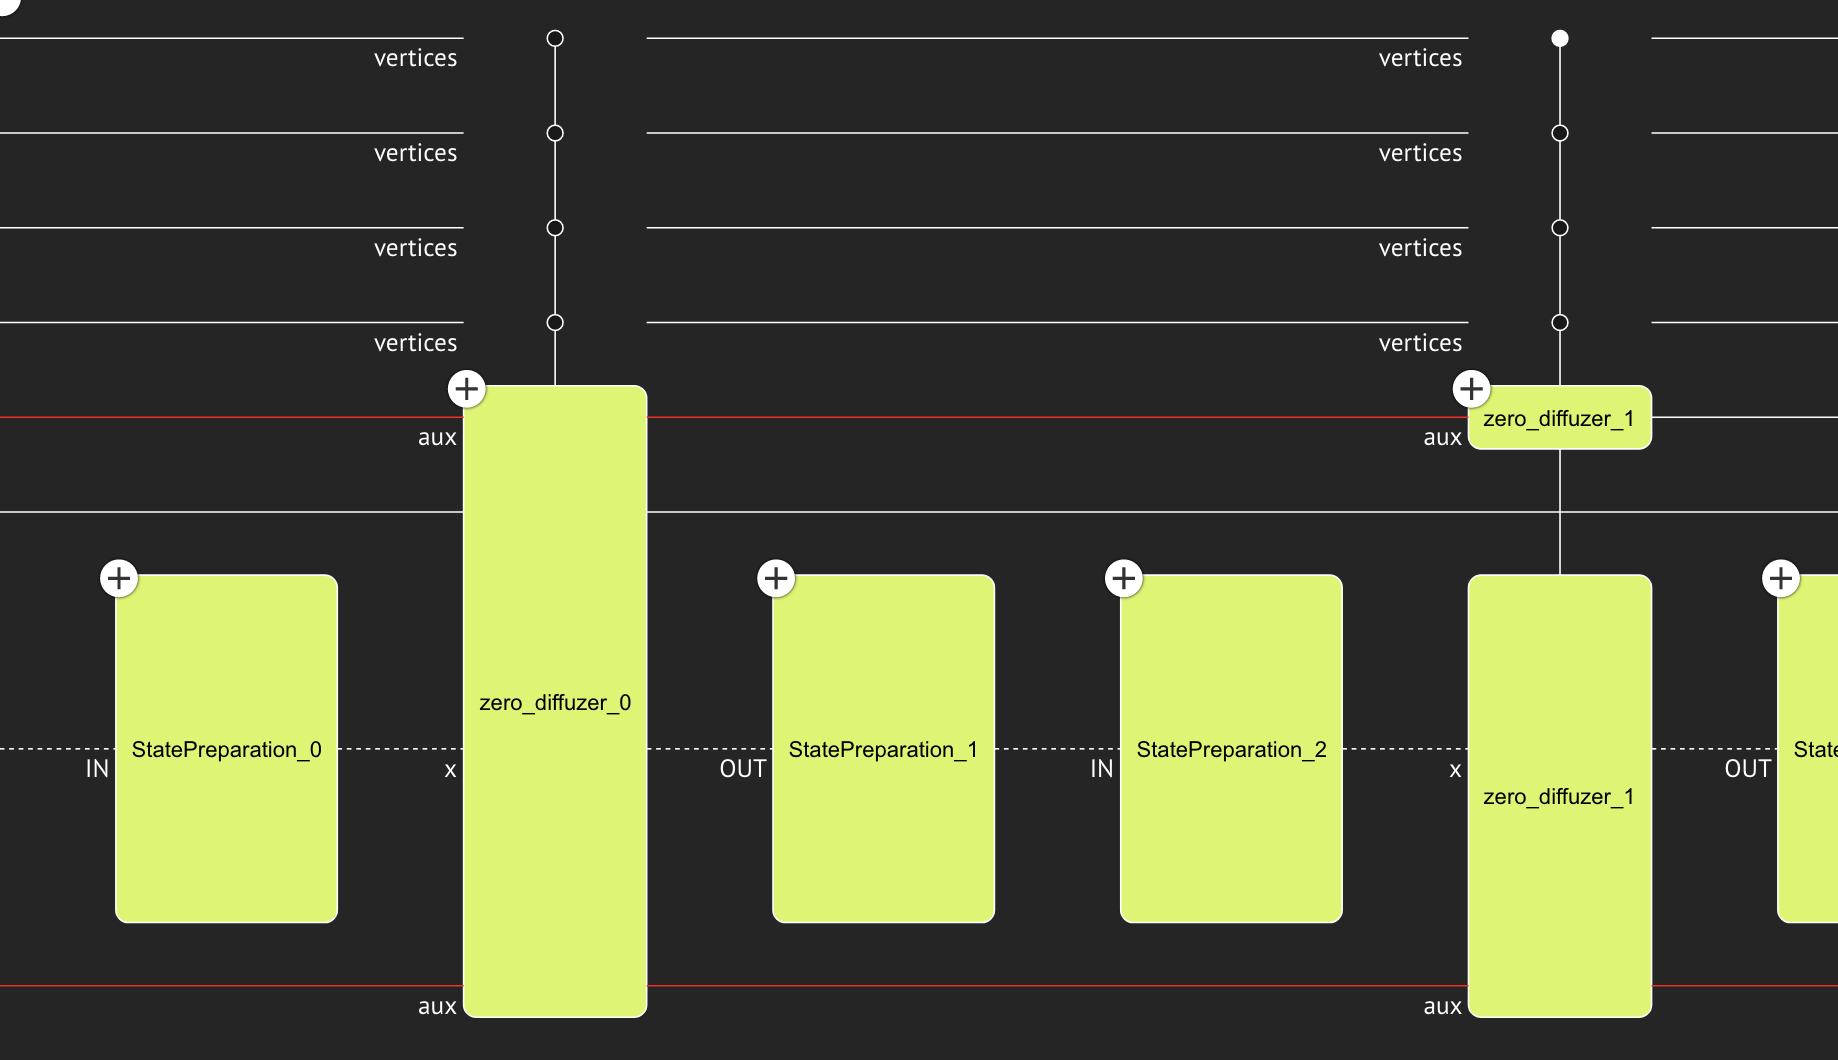

### Inside the shift operator

The shift operator expansion is shown below (once again, this is only part of the circuit). The edge oracle function shows up here, which tells us if two vertices are connected via an edge.

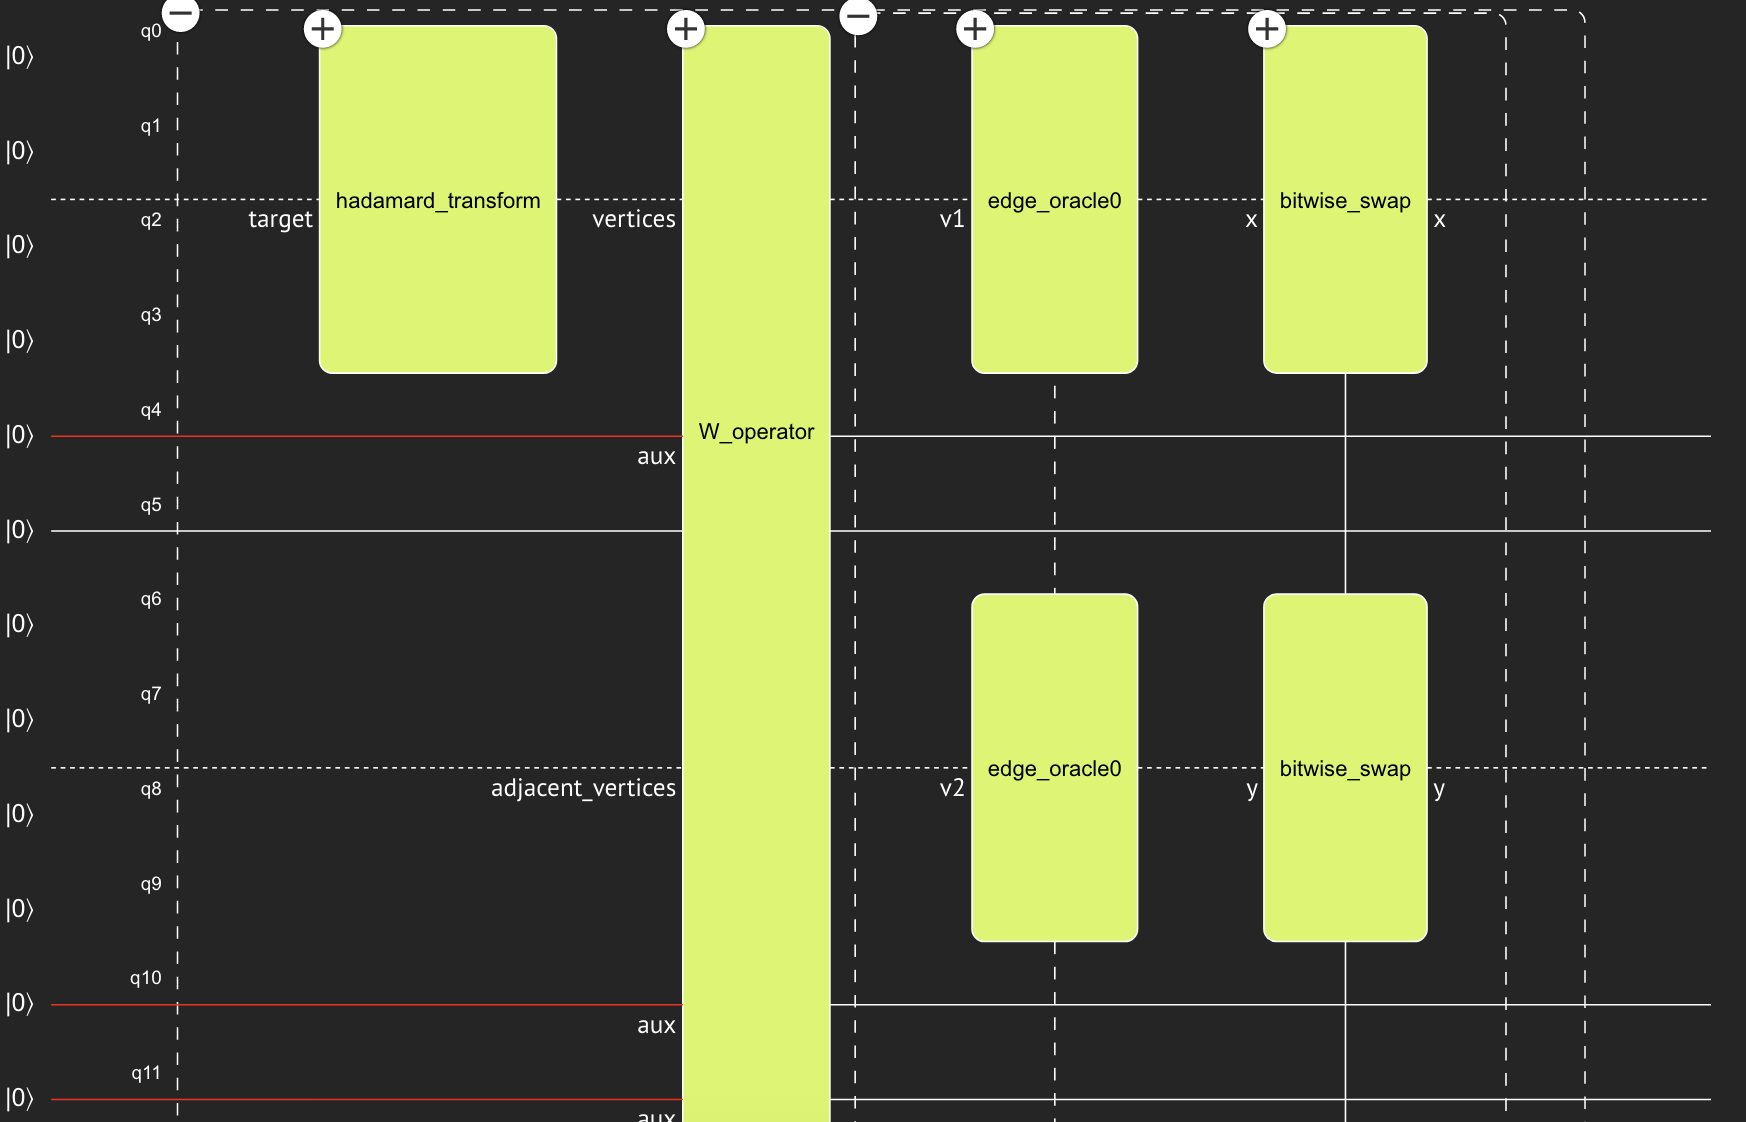

### Optimizing the circuit

Let's try to optimize the circuit for **width** since we are using a few too many bits. If successful, we would like to `execute` this quantum program in a simulator to further analyze the results.

In [64]:
from classiq import (
    Constraints, set_constraints, QuantumProgram
)
from classiq.exceptions import ClassiqAPIError

def fn_constraint1(qm):
    return set_constraints(
        qm, 
        Constraints(optimization_parameter="width")
    )

def fn_constraint2(qm):
    return set_constraints(
        qm, 
        Constraints(optimization_parameter="depth")
    )

def fn_constraint3(qm):
    return set_constraints(
        qm, 
        Constraints(max_width=25)
    )

def find_a_good_circuit(qm):
    for fn_c, cn in [
            (lambda x: x, "no-change"),
            (fn_constraint2, "depth"),
            (fn_constraint1, "width"),
            (fn_constraint3, "something in between"),
    ]:
        print(f"INFO: Constraint on {cn}")
        qm_with_constraints = fn_c(qm)
        try:
            qprog = synthesize(qm_with_constraints)
            qpg = QuantumProgram.from_qprog(qprog)
            ops = qpg.transpiled_circuit.count_ops
            width = qpg.data.width
            depth = qpg.transpiled_circuit.depth
            t_ops = sum(ops[k] for k in ops.keys())
            print(f"  Transpiled circuit width: "
                  f"{width}, depth: {depth}, ops: {ops}, total gates: {t_ops}")
        except ClassiqAPIError as err:
            # print(err)
            print("Constraint(s) could bot be satisfied")


We attempt various optimzation constraints and try all combinations of edge oracle as well. 

In [65]:
for i in range(4):
    print(f"=== Using edge-oracle_{i} ===")
    qm = custom_model(num_qubits=4, e_oracle_selector=i, quiet=True)
    find_a_good_circuit(qm)

=== Using edge-oracle_0 ===
INFO: Constraint on no-change
  Transpiled circuit width: 37, depth: 2948, ops: {'u': 2697, 'cx': 2565}, total gates: 5262
INFO: Constraint on depth
  Transpiled circuit width: 177, depth: 2217, ops: {'u': 2397, 'cx': 2142}, total gates: 4539
INFO: Constraint on width
  Transpiled circuit width: 37, depth: 2778, ops: {'u': 3334, 'cx': 3166}, total gates: 6500
INFO: Constraint on something in between
Constraint(s) could bot be satisfied
=== Using edge-oracle_1 ===
INFO: Constraint on no-change
  Transpiled circuit width: 41, depth: 2778, ops: {'u': 2477, 'cx': 2352}, total gates: 4829
INFO: Constraint on depth
  Transpiled circuit width: 173, depth: 2045, ops: {'u': 2229, 'cx': 1986}, total gates: 4215
INFO: Constraint on width
  Transpiled circuit width: 37, depth: 2652, ops: {'u': 3056, 'cx': 2910}, total gates: 5966
INFO: Constraint on something in between
Constraint(s) could bot be satisfied
=== Using edge-oracle_2 ===
INFO: Constraint on no-change
  Tran

### Too many qubits for a 16 node system
Since the maximum number of qubits supported by Classiq IDE at the moment is **25** and our best circuit requires more, we can't execute this unfortunately.

* Note: `edge-oracle_3` did not yield any result because `classiq.qmod.symbolic.abs` is not working at the current `classiq` released version.

### Try a 8 node system
Let's try to build a solution with 8 nodes, or 3 bits for vertices. This is just so that we can analyze the behavior on simulator.

In [66]:
# we can run this only for a 8 node grapth, i.e. 3 qubits for vertices
qmod = custom_model(num_qubits=3, e_oracle_selector=2)
qm_with_constraints = set_constraints(qmod, Constraints(optimization_parameter="width"))
qprog = synthesize(qm_with_constraints)
# show(qprog)
res = execute(qprog).result()

State= 0, prob vec =[0, 1.0, 0, 0, 0, 0, 0, 0]
State= 1, prob vec =[0.5, 0, 0.5, 0, 0, 0, 0, 0]
State= 2, prob vec =[0, 0.5, 0, 0.5, 0, 0, 0, 0]
State= 3, prob vec =[0, 0, 0.5, 0, 0.5, 0, 0, 0]
State= 4, prob vec =[0, 0, 0, 0.5, 0, 0.5, 0, 0]
State= 5, prob vec =[0, 0, 0, 0, 0.5, 0, 0.5, 0]
State= 6, prob vec =[0, 0, 0, 0, 0, 0.5, 0, 0.5]
State= 7, prob vec =[0, 0, 0, 0, 0, 0, 1.0, 0]


In [67]:
res[0].value

ExecutionDetails(vendor_format_result={}, counts={'000101': 265, '001000': 248, '000100': 274, '000110': 265, '000010': 260, '000000': 253, '000011': 244, '000111': 239}, counts_lsb_right=True, parsed_states={'000101': {'vertices': 5.0, 'adjacent_vertices': 0.0}, '001000': {'vertices': 0.0, 'adjacent_vertices': 1.0}, '000100': {'vertices': 4.0, 'adjacent_vertices': 0.0}, '000110': {'vertices': 6.0, 'adjacent_vertices': 0.0}, '000010': {'vertices': 2.0, 'adjacent_vertices': 0.0}, '000000': {'vertices': 0.0, 'adjacent_vertices': 0.0}, '000011': {'vertices': 3.0, 'adjacent_vertices': 0.0}, '000111': {'vertices': 7.0, 'adjacent_vertices': 0.0}}, histogram=None, output_qubits_map={'vertices': (0, 1, 2), 'adjacent_vertices': (3, 4, 5)}, state_vector=None, parsed_state_vector_states=None, physical_qubits_map={'vertices': (3, 4, 5), 'adjacent_vertices': (0, 1, 2)}, num_shots=2048)

In [68]:
res[0].value.parsed_states

{'000101': {'vertices': 5.0, 'adjacent_vertices': 0.0},
 '001000': {'vertices': 0.0, 'adjacent_vertices': 1.0},
 '000100': {'vertices': 4.0, 'adjacent_vertices': 0.0},
 '000110': {'vertices': 6.0, 'adjacent_vertices': 0.0},
 '000010': {'vertices': 2.0, 'adjacent_vertices': 0.0},
 '000000': {'vertices': 0.0, 'adjacent_vertices': 0.0},
 '000011': {'vertices': 3.0, 'adjacent_vertices': 0.0},
 '000111': {'vertices': 7.0, 'adjacent_vertices': 0.0}}